There could be erros, mistakes. Feedback is always welcome.

>[Simulating value of simple covered-call portfolio over specific periods](#scrollTo=NeSbgLLBVumY&uniqifier=2)

>[Movement between CONY ETF and Coinbase stock price and Bitcoin price.](#scrollTo=93SVvZKemS-0&uniqifier=2)

>[Comparisons of other notable high yield covered call etf TSLY NVDY with their base asset(TSLA NVDA each)](#scrollTo=fLq1amzUufno&uniqifier=2)

>[Predicts value of CONY](#scrollTo=fLq1amzUufno&uniqifier=2)



In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from math import exp, log, sqrt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

In [2]:
def get_data(ticker, periods='1y', rename=None, only_price=False):
  """
  ticker : Object of yf.Ticker
  periods : Data periods
  rename : List of new column names are required if renaming is necessary
  only_price :Getting only price data if other data is not essential
  """
  columns = ['Close'] if only_price == True else ['Close','Volume']
  ticker_hist = ticker.history(period=periods)
  ticker_hist = ticker_hist[columns]
  rename = ['price'] if ((rename == None) and (only_price == True)) else rename
  ticker_hist.columns = rename
  ticker_hist = ticker_hist.reset_index()
  ticker_hist['Date'] = pd.to_datetime(ticker_hist['Date']).dt.strftime('%Y-%m-%d')
  return ticker_hist

In [3]:
def scaler(df):
  scaler = StandardScaler()
  scaled_df = scaler.fit_transform(df)
  scaled_df = pd.DataFrame(scaled_df, columns=df.columns)
  return scaled_df

# Simulating value of simple covered-call portfolio over specific periods

In [ ]:
def black_scholes_call(S, K, T, r, sigma):
    d1 = (log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = d1 - sigma * sqrt(T)
    call_price = S * norm.cdf(d1) - K * exp(-r * T) * norm.cdf(d2)
    return call_price

In [ ]:
def covered_call_value(start_b, start_s, days, M, s_v, threshold, fee):
  """
  c_prm : Call option premium
  b : Latest portfolio value
  s : Latest spot price
  x : Latest strike price
  b_lst : List of portfolio values
  s_lst : List of spot prices
  x_lst : List of strike prices
  """
  c_prm = black_scholes_call(start_s, start_s*(1.05), days, 0.02, s_v)
  b = (start_b - start_s) + c_prm + start_s
  s = start_s
  x = start_s*(1.05)
  b_lst = []
  s_lst = []
  x_lst = []

  b_lst.append(b)
  s_lst.append(s)
  x_lst.append(x)
  for j in range(M):
    rnd_lst = [random.random() for _ in range(days)]
    print(f"{j} month")
    for i in range(days):
      if rnd_lst[i] >= threshold:
        s = s + (s*s_v)
      else:
        s = s - (s*s_v)
      print(f"day {i} price is {s}")
      # s_lst.append(round(s,4))
    s_lst.append(round(s,4))
    x = round(s+(s*0.05),4) # calculate new strike price of new call option for next 30days
    x_lst.append(x)
    # c_prm = black_scholes_call(s_lst[-1], x_lst[-1], days, 0.02, s_v) # calculate new premium of new call option, whose strike price is updated.
    c_prm = round(5 + max(x_lst[-1] - s_lst[-1], 0),4)
    if s_lst[-1] <= x_lst[j]: # otm
      b = b_lst[j] + (s_lst[-1]-s_lst[j]) + c_prm
      b_lst.append(b)
    else: # itm
      borrow = abs(b_lst[j] - s_lst[-1])
      b = c_prm - borrow
      b_lst.append(b)
    print(f"s : {s_lst[-1]} and x : {x_lst[-1]} and x/s = {round(x_lst[-1]/s_lst[-1],4)} and x-s = {round(x_lst[-1] - s_lst[-1],4)}, c_prm : {c_prm}, pf-value : {b_lst[-1]}")
  return (b_lst, s_lst, x_lst)

Simulation down below shows the value of covered-call portfolio. Probability of stock(=spot) price goes down is little bit higher, which means there are merely downward trend in the market. I assumed covered-call portfolio is rebalanced at the end of maturity by repositioning(buy stock sell call option if call option buyer exercises right, otherwise just keeping stock and selling call option). However since person who owns coverd-call portfolio roll its position, this assumption might unrealistic. Reason for this unrealistic assumption is, i just watnted to visualize very simple(very beginner level) covered-call portfolio. And also, by doing this simple simulation, we can understand the importance of rolling rather purely taking position with spot and options.
Here is the link where explains about rolling of covered-call position : https://www.fidelity.com/learning-center/investment-products/options/rolling-covered-calls

In [ ]:
# options are assumed only for call option
current_b = 100 # current port value
current_s = 100
s_v = 0.005 # stock price volatility. Unlike real world, it is constant for my simulation.
days = 30 # i assumed there are 30 days per month.
M = 36 # month
pf_value_lst = []
sp_price_lst = []
threshold = 0.51 # controls tendency of stock movement. If threshold is less than 0.5 then, it implies there are more liklihood for stock price move upward.
fee = 0.009
b_lst1, s_lst1, x_lst1 = covered_call_value(current_b, current_s, days, M, s_v, threshold,fee)


It might unusual to see covered call portfolio value decreases when stock price goes up. However since i assumed buying stock to reposition even if stock price sky rocketed, portfoilio needs to loan money to purchase expensive stock(reason why  portfollio value.can be negative).

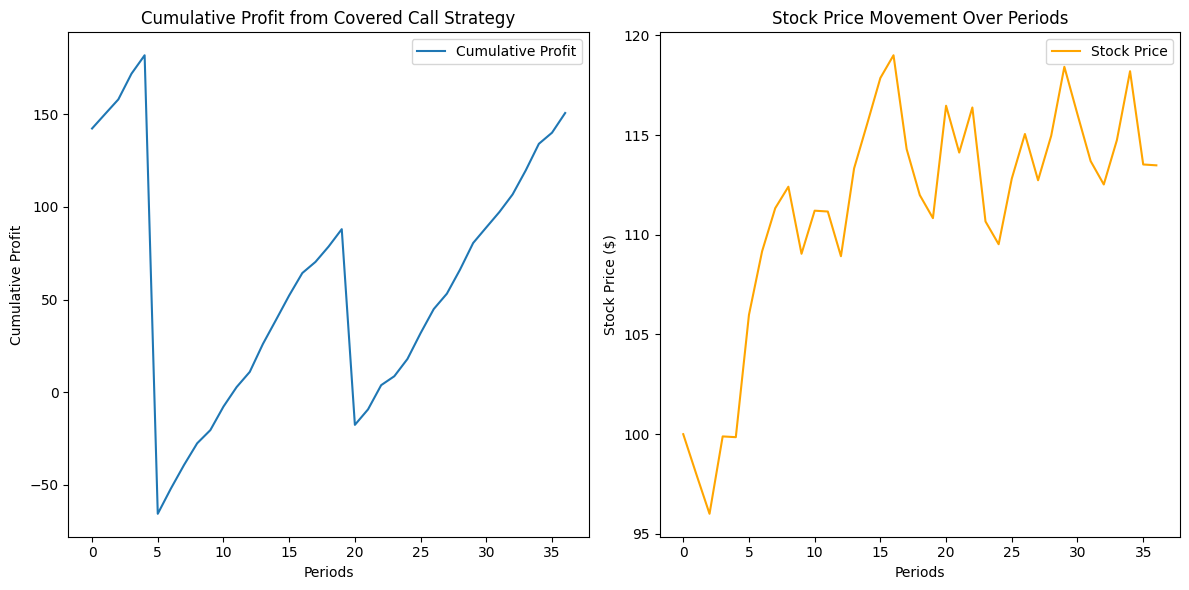

In [ ]:
# visualize the result
plt.figure(figsize=(12, 6))

# cumulative return of covered-call portfolio
plt.subplot(1, 2, 1)
plt.plot(b_lst1, label="Cumulative Profit")
plt.xlabel("Periods")
plt.ylabel("Cumulative Profit")
plt.title("Cumulative Profit from Covered Call Strategy")
plt.legend()

# stock price grpah
plt.subplot(1, 2, 2)
plt.plot(s_lst1, label="Stock Price", color="orange")
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

plt.tight_layout()
plt.show()

# Movement between CONY ETF and Coinbase stock price and Bitcoin price.

In [4]:
cony = yf.Ticker("CONY")
coin = yf.Ticker("COIN")
bit = yf.Ticker('BTC-USD')

cony_hist = get_data(cony, rename=['cony_price','cony_volume'])
coin_hist = get_data(coin, rename=['coin_price','coin_volume'])
bit_hist = get_data(bit, rename=['bit_price','bit_volume'])

df_cc = cony_hist.merge(coin_hist, on='Date', how='outer')
df = df_cc.merge(bit_hist, on='Date', how='outer')
df = df.dropna()
df = df.reset_index().drop(columns=['index'])
df

,Date,cony_price,cony_volume,coin_price,coin_volume,bit_price,bit_volume
0,2023-11-21,8.529226,165600.0,105.489998,9348200.0,35813.812500,2.517216e+10
1,2023-11-22,8.593623,136600.0,109.250000,10340100.0,37432.339844,2.439725e+10
2,2023-11-24,8.665177,111600.0,115.540001,11654600.0,37720.281250,2.292296e+10
3,2023-11-27,8.679488,256600.0,119.769997,14205900.0,37254.167969,1.900293e+10
4,2023-11-28,8.901304,197100.0,128.270004,17639100.0,37831.085938,2.169614e+10
...,...,...,...,...,...,...,...
246,2024-11-13,15.457000,13792500.0,284.720001,27997400.0,90584.164062,1.235590e+11
247,2024-11-14,15.070000,8854100.0,278.839996,17375300.0,87250.429688,8.761671e+10
248,2024-11-15,16.260000,5305600.0,305.850006,18020600.0,91066.007812,7.824311e+10
249,2024-11-18,16.969999,6420200.0,325.410004,25713700.0,90542.640625,7.553578e+10


since bitcoin price's unit is different compare to coinbase stock price and cony price, let's normalize each values.

<Axes: >

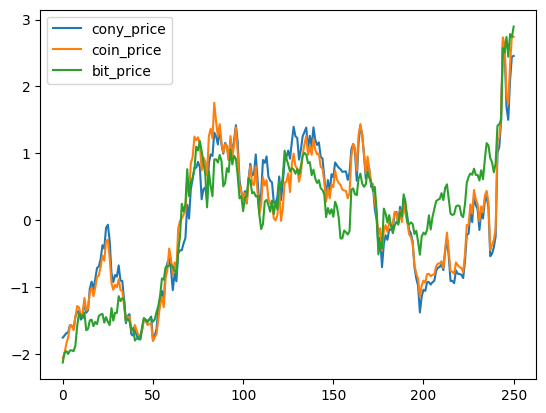

In [5]:
price_df = df[['cony_price','coin_price','bit_price']]
scaled_price_df = scaler(price_df)
scaled_price_df.plot()

In [6]:
# let's see correlations
price_df_corr_mat = price_df.corr()
price_df_corr_mat

,cony_price,coin_price,bit_price
cony_price,1.000000,0.980949,0.844540
coin_price,0.980949,1.000000,0.884908
bit_price,0.844540,0.884908,1.000000


# Comparisons of other notable high yield covered call etf TSLY NVDY with their base asset(TSLA NVDA each)

In [7]:
tsly = yf.Ticker("TSLY")
tsla = yf.Ticker("TSLA")
nvdy = yf.Ticker("NVDY")
nvda = yf.Ticker("NVDA")

tsly_hist = get_data(tsly, periods='6mo', rename=['tsly_price'], only_price=True)
tsla_hist = get_data(tsla, periods='6mo', rename=['tsla_price'], only_price=True)
nvdy_hist = get_data(nvdy, periods='6mo', rename=['nvdy_price'], only_price=True)
nvda_hist = get_data(nvda, periods='6mo', rename=['nvda_price'], only_price=True)

df_ts = tsly_hist.merge(tsla_hist, on='Date', how='outer')
df_nv = nvdy_hist.merge(nvda_hist, on='Date', how='outer')
# df_ts

In [8]:
scaled_ts_df = scaler(df_ts[['tsly_price','tsla_price']])
scaled_nv_df = scaler(df_nv[['nvdy_price','nvda_price']])

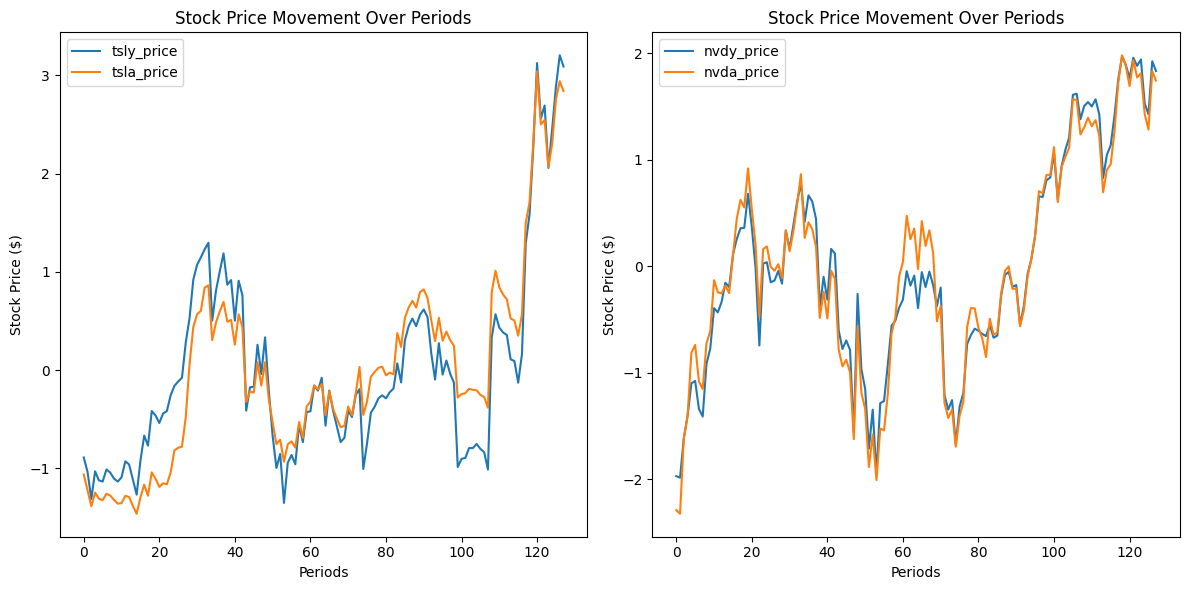

In [9]:
# visualize the result
plt.figure(figsize=(12, 6))

# cumulative return of covered-call portfolio
plt.subplot(1, 2, 1)
plt.plot(scaled_ts_df, label=['tsly_price','tsla_price'])
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

# stock price grpah
plt.subplot(1, 2, 2)
plt.plot(scaled_nv_df, label=['nvdy_price','nvda_price'])
plt.xlabel("Periods")
plt.ylabel("Stock Price ($)")
plt.title("Stock Price Movement Over Periods")
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
df_ts_corr_mat = scaled_ts_df.corr()
df_nv_corr_mat = scaled_nv_df.corr()

In [11]:
df_ts_corr_mat

,tsly_price,tsla_price
tsly_price,1.000000,0.933452
tsla_price,0.933452,1.000000


In [12]:
df_nv_corr_mat

,nvdy_price,nvda_price
nvdy_price,1.000000,0.982619
nvda_price,0.982619,1.000000


# Predicts value of CONY

I am going to make a model that can predicts future price of CONY. Prediction process implementation is as follows :

1. Make SVR model first, fit it.
2. Assume cony_volume, coin_price, coin_volume move upward.
3. Next Assume those features go down.

So, we are going to see price movement of CONY in two secnarios.

In [13]:
# 'df' is price data for cony, coinbase, bitcoin
cony_coin_df = df[['Date','cony_price','cony_volume','coin_price','coin_volume','bit_price','bit_volume']]
cony_coin_df

,Date,cony_price,cony_volume,coin_price,coin_volume,bit_price,bit_volume
0,2023-11-21,8.529226,165600.0,105.489998,9348200.0,35813.812500,2.517216e+10
1,2023-11-22,8.593623,136600.0,109.250000,10340100.0,37432.339844,2.439725e+10
2,2023-11-24,8.665177,111600.0,115.540001,11654600.0,37720.281250,2.292296e+10
3,2023-11-27,8.679488,256600.0,119.769997,14205900.0,37254.167969,1.900293e+10
4,2023-11-28,8.901304,197100.0,128.270004,17639100.0,37831.085938,2.169614e+10
...,...,...,...,...,...,...,...
246,2024-11-13,15.457000,13792500.0,284.720001,27997400.0,90584.164062,1.235590e+11
247,2024-11-14,15.070000,8854100.0,278.839996,17375300.0,87250.429688,8.761671e+10
248,2024-11-15,16.260000,5305600.0,305.850006,18020600.0,91066.007812,7.824311e+10
249,2024-11-18,16.969999,6420200.0,325.410004,25713700.0,90542.640625,7.553578e+10


Used the code from here : https://github.com/bellmcp/Machine-Learning-Price-Prediction/blob/master/ML%20Project%20SVR%206033657523.ipynb

Since we have small amount of data, i'll use Support Vector Regression, which is known for good at small number of data and also good for non-linear data

In [30]:
X = cony_coin_df[['cony_volume','coin_price','coin_volume','bit_price','bit_volume']]
y = cony_coin_df['cony_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Data Preprocessing. Do scaling to make data's scale is approporiate for SVR
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model training
svr_model = SVR(kernel='linear', C=100.0, epsilon=0.1) # kernel is linear since it shows better result than poly, rbf.
svr_model.fit(X_train_scaled, y_train)

# Evaluate Model
y_pred = svr_model.predict(X_test_scaled)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.28037531792244913


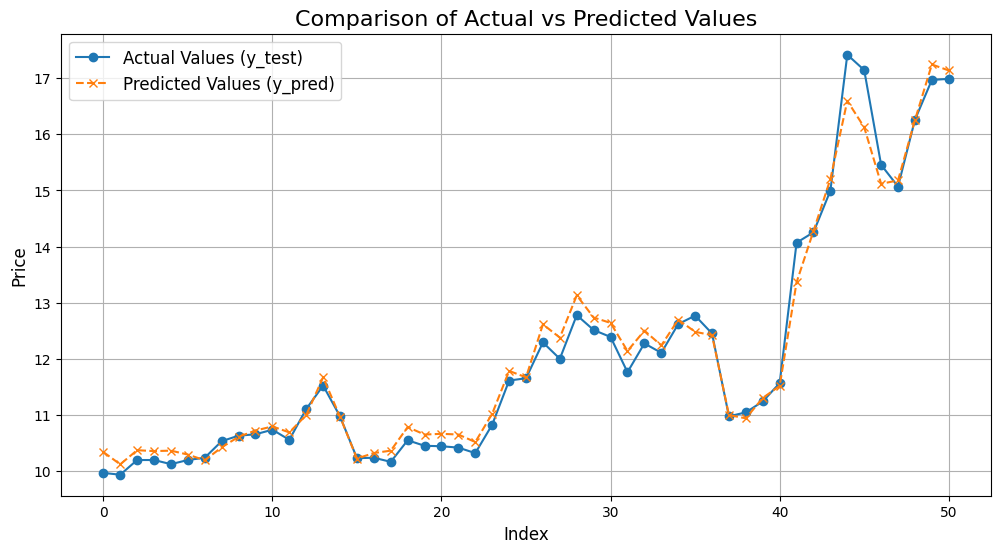

In [53]:
# Let's see how our model predicted
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Values (y_test)", linestyle='-', marker='o')
plt.plot(y_pred, label="Predicted Values (y_pred)", linestyle='--', marker='x')

plt.title("Comparison of Actual vs Predicted Values", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Make sythesized future price data for cony.

<ipython-input-61-34b75f9d1cc9>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  past_data['Log_Returns'] = np.log(past_data['cony_price'] / past_data['cony_price'].shift(1))


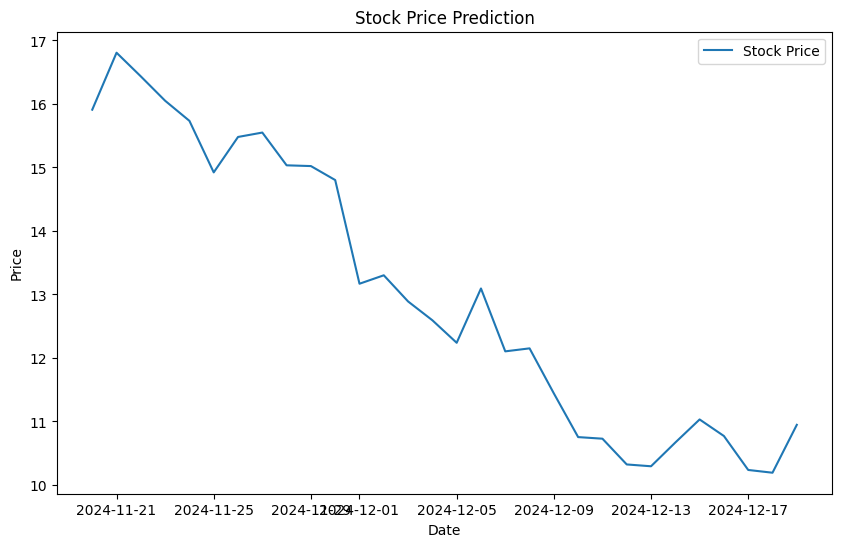

In [61]:
past_data = cony_coin_df[['Date','cony_price']]

# Calculate returns: use log returns
past_data['Log_Returns'] = np.log(past_data['cony_price'] / past_data['cony_price'].shift(1))
mean_return = past_data['Log_Returns'].mean()
std_return = past_data['Log_Returns'].std()

# Generate future stock prices for n days
n = 30  # Number of future days
future_dates = pd.date_range(start=pd.to_datetime(past_data['Date']).iloc[-1] + pd.Timedelta(days=1), periods=n)
future_returns = np.random.normal(mean_return, std_return, size=n)

# Generate future stock prices (starting with the last cony_price)
future_prices = [past_data['cony_price'].iloc[-1]]
for r in future_returns:
    future_prices.append(future_prices[-1] * np.exp(r))

# Create a DataFrame for future data
future_data = pd.DataFrame({
    'Date': future_dates,
    'cony_price': future_prices[1:]  # Exclude the first value
})

# Visualize syenthesized future price data
plt.figure(figsize=(10, 6))
plt.plot(future_data['Date'], future_data['cony_price'], label='Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Prdiects price data of future using trained model

In [90]:
# Calculate log returns for each feature
cony_coin_df_copy = cony_coin_df.copy()
cony_coin_df_copy['cony_volume_log_chg'] = np.log(cony_coin_df['cony_volume'] / cony_coin_df['cony_volume'].shift(1))
cony_coin_df_copy['coin_price_log_chg'] = np.log(cony_coin_df['coin_price'] / cony_coin_df['coin_price'].shift(1))
cony_coin_df_copy['coin_volume_log_chg'] = np.log(cony_coin_df['coin_volume'] / cony_coin_df['coin_volume'].shift(1))
cony_coin_df_copy['bit_price_log_chg'] = np.log(cony_coin_df['bit_price'] / cony_coin_df['bit_price'].shift(1))
cony_coin_df_copy['bit_volume_log_chg'] = np.log(cony_coin_df['bit_volume'] / cony_coin_df['bit_volume'].shift(1))

# Calculate mean and standard deviation of log changes for each feature
log_return_stats = {
    'cony_volume': (cony_coin_df_copy['cony_volume_log_chg'].mean(), cony_coin_df_copy['cony_volume_log_chg'].std()),
    'coin_price': (cony_coin_df_copy['coin_price_log_chg'].mean(), cony_coin_df_copy['coin_price_log_chg'].std()),
    'coin_volume': (cony_coin_df_copy['coin_volume_log_chg'].mean(), cony_coin_df_copy['coin_volume_log_chg'].std()),
    'bit_price': (cony_coin_df_copy['bit_price_log_chg'].mean(), cony_coin_df_copy['bit_price_log_chg'].std()),
    'bit_volume': (cony_coin_df_copy['bit_volume_log_chg'].mean(), cony_coin_df_copy['bit_volume_log_chg'].std()),
}

num_future_steps = n  # Number of future steps to predict

# Generate future changes (log returns) for each feature
future_changes_cnyv = np.random.normal(log_return_stats['cony_volume'][0], log_return_stats['cony_volume'][1], size=num_future_steps)
future_changes_coinp = np.random.normal(log_return_stats['coin_price'][0], log_return_stats['coin_price'][1], size=num_future_steps)
future_changes_coinv = np.random.normal(log_return_stats['coin_volume'][0], log_return_stats['coin_volume'][1], size=num_future_steps)
future_changes_bitp = np.random.normal(log_return_stats['bit_price'][0], log_return_stats['bit_price'][1], size=num_future_steps)
future_changes_bitv = np.random.normal(log_return_stats['bit_volume'][0], log_return_stats['bit_volume'][1], size=num_future_steps)


# Original data.
last_known_data = cony_coin_df.iloc[-1][['cony_volume','coin_price','coin_volume','bit_price','bit_volume']].values

# Initialize future feature list starting from the last known data
future_features = []  # Start with the last known data
future_predictions = []  # List to store future price predictions

# Generate future feature values
for i in range(num_future_steps):
    next_features = last_known_data.copy()  # Copy the last feature values
    next_features[0] *= np.exp(future_changes_cnyv[i])  # cony_volume
    next_features[1] *= np.exp(future_changes_coinp[i])  # coin_price
    next_features[2] *= np.exp(future_changes_coinv[i])  # coin_volume
    next_features[3] *= np.exp(future_changes_bitp[i])  # bit_price
    next_features[4] *= np.exp(future_changes_bitv[i])  # bit_volume
    future_features.append(next_features)  # Add to future features list

# Convert the list to a numpy array
future_features = np.array(future_features)

# Scaling
scaled_future_features = scaler.transform(future_features)

# Predict prices
for scaled_data in scaled_future_features:
  next_prediction = svr_model.predict(scaled_data.reshape(1,-1))[0]  # Predict using the SVR model
  print("scaled features: ", scaled_data)
  future_predictions.append(next_prediction)

# Print results
print("Future Predictions:", future_predictions)

scaled features:  [2.86658998 3.10701202 0.29868813 3.00809974 2.3607021 ]
scaled features:  [7.41743555 2.91318705 0.45857035 3.21935437 2.58930014]
scaled features:  [3.71887435 2.28142432 0.36018004 3.19464157 3.34280506]
scaled features:  [9.08379827 2.50567731 0.5151298  2.70348526 2.3957914 ]
scaled features:  [13.85787768  3.08944538  3.30847062  3.89474008  1.61883569]
scaled features:  [2.73742109 2.36103388 0.5203406  3.7737378  3.19166157]
scaled features:  [ 2.31518239  3.72534007 -0.22641231  3.34325417  2.11906164]
scaled features:  [2.35131049 2.907464   0.27798439 3.09082842 7.07021794]
scaled features:  [6.17215535 2.94903685 0.48651443 2.9656573  3.13693747]
scaled features:  [4.73158859 3.1640823  0.81499611 3.40507439 4.43789199]
scaled features:  [5.54237688 2.84584534 4.08892967 3.35788219 0.75989416]
scaled features:  [6.7314121  3.29626761 0.87116538 3.44365398 4.32665754]
scaled features:  [7.94093767 2.81372147 0.11507488 3.31964099 2.1798674 ]
scaled features

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


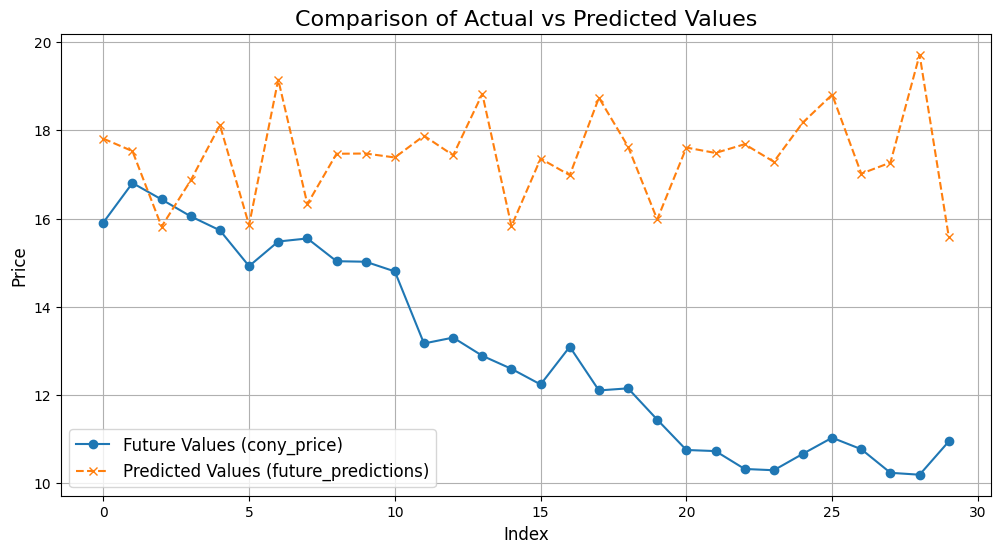

In [91]:
# Let's see how our model predicted for future data
plt.figure(figsize=(12, 6))
plt.plot(future_data['cony_price'], label="Future Values (cony_price)", linestyle='-', marker='o')
plt.plot(future_predictions, label="Predicted Values (future_predictions)", linestyle='--', marker='x')

plt.title("Comparison of Actual vs Predicted Values", fontsize=16)
plt.xlabel("Index", fontsize=12)
plt.ylabel("Price", fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

Predicted price from svr model may be much accurate than synthesized future price, since synthesized price is just normal random variable which mean is historical mean return of cony and standard deviation is also derived from the historical return cony